In [ ]:
pip install pyspark

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install xgboost

## Library

In [ ]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql.functions import col, sum, when
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler
from sklearn.metrics import classification_report, confusion_matrix

#library model
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator
from pyspark.mllib.evaluation import BinaryClassificationMetrics
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.classification import GBTClassifier
from sklearn.metrics import roc_curve, auc

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd



In [ ]:
spark = SparkSession.builder.appName("HeartDiseasePrediction").getOrCreate()
df = spark.read.csv("/content/drive/MyDrive/BigDataLanjut/Dataset/heart.csv", header=True, inferSchema=True)

## **PREPROCESSING DATA**

In [ ]:
# Menghitung jumlah nilai null di setiap kolom
null_counts = df.select([sum(when(col(c).isNull(), 1).otherwise(0)).alias(c) for c in df.columns])

null_counts.show()

+---+---+---+--------+----+---+-------+-------+-----+-------+-----+---+----+------+
|age|sex| cp|trestbps|chol|fbs|restecg|thalach|exang|oldpeak|slope| ca|thal|target|
+---+---+---+--------+----+---+-------+-------+-----+-------+-----+---+----+------+
|  0|  0|  0|       0|   0|  0|      0|      0|    0|      0|    0|  0|   0|     0|
+---+---+---+--------+----+---+-------+-------+-----+-------+-----+---+----+------+



In [ ]:
df.printSchema()

root
 |-- age: integer (nullable = true)
 |-- sex: integer (nullable = true)
 |-- cp: integer (nullable = true)
 |-- trestbps: integer (nullable = true)
 |-- chol: integer (nullable = true)
 |-- fbs: integer (nullable = true)
 |-- restecg: integer (nullable = true)
 |-- thalach: integer (nullable = true)
 |-- exang: integer (nullable = true)
 |-- oldpeak: double (nullable = true)
 |-- slope: integer (nullable = true)
 |-- ca: integer (nullable = true)
 |-- thal: integer (nullable = true)
 |-- target: integer (nullable = true)



In [ ]:
df.show()

+---+---+---+--------+----+---+-------+-------+-----+-------+-----+---+----+------+
|age|sex| cp|trestbps|chol|fbs|restecg|thalach|exang|oldpeak|slope| ca|thal|target|
+---+---+---+--------+----+---+-------+-------+-----+-------+-----+---+----+------+
| 63|  1|  3|     145| 233|  1|      0|    150|    0|    2.3|    0|  0|   1|     1|
| 37|  1|  2|     130| 250|  0|      1|    187|    0|    3.5|    0|  0|   2|     1|
| 41|  0|  1|     130| 204|  0|      0|    172|    0|    1.4|    2|  0|   2|     1|
| 56|  1|  1|     120| 236|  0|      1|    178|    0|    0.8|    2|  0|   2|     1|
| 57|  0|  0|     120| 354|  0|      1|    163|    1|    0.6|    2|  0|   2|     1|
| 57|  1|  0|     140| 192|  0|      1|    148|    0|    0.4|    1|  0|   1|     1|
| 56|  0|  1|     140| 294|  0|      0|    153|    0|    1.3|    1|  0|   2|     1|
| 44|  1|  1|     120| 263|  0|      1|    173|    0|    0.0|    2|  0|   3|     1|
| 52|  1|  2|     172| 199|  1|      1|    162|    0|    0.5|    2|  0|   3|

In [ ]:
#mencetak setiap nama kolom diikuti dengan deskripsinya
info = ["age","1: male, 0: female","chest pain type, 1: typical angina, 2: atypical angina, 3: non-anginal pain, 4: asymptomatic","resting blood pressure"," serum cholestoral in mg/dl","fasting blood sugar > 120 mg/dl","resting electrocardiographic results (values 0,1,2)"," maximum heart rate achieved","exercise induced angina","oldpeak = ST depression induced by exercise relative to rest","the slope of the peak exercise ST segment","number of major vessels (0-3) colored by flourosopy","thal: 3 = normal; 6 = fixed defect; 7 = reversable defect"]



for i in range(len(info)):
    print(df.columns[i]+":\t\t\t"+info[i])

age:			age
sex:			1: male, 0: female
cp:			chest pain type, 1: typical angina, 2: atypical angina, 3: non-anginal pain, 4: asymptomatic
trestbps:			resting blood pressure
chol:			 serum cholestoral in mg/dl
fbs:			fasting blood sugar > 120 mg/dl
restecg:			resting electrocardiographic results (values 0,1,2)
thalach:			 maximum heart rate achieved
exang:			exercise induced angina
oldpeak:			oldpeak = ST depression induced by exercise relative to rest
slope:			the slope of the peak exercise ST segment
ca:			number of major vessels (0-3) colored by flourosopy
thal:			thal: 3 = normal; 6 = fixed defect; 7 = reversable defect


In [ ]:
df = df.withColumnRenamed("cp", "chest_pain") \
       .withColumnRenamed("ca", "coronary_arteries")

df.show()

+---+---+----------+--------+----+---+-------+-------+-----+-------+-----+-----------------+----+------+
|age|sex|chest_pain|trestbps|chol|fbs|restecg|thalach|exang|oldpeak|slope|coronary_arteries|thal|target|
+---+---+----------+--------+----+---+-------+-------+-----+-------+-----+-----------------+----+------+
| 63|  1|         3|     145| 233|  1|      0|    150|    0|    2.3|    0|                0|   1|     1|
| 37|  1|         2|     130| 250|  0|      1|    187|    0|    3.5|    0|                0|   2|     1|
| 41|  0|         1|     130| 204|  0|      0|    172|    0|    1.4|    2|                0|   2|     1|
| 56|  1|         1|     120| 236|  0|      1|    178|    0|    0.8|    2|                0|   2|     1|
| 57|  0|         0|     120| 354|  0|      1|    163|    1|    0.6|    2|                0|   2|     1|
| 57|  1|         0|     140| 192|  0|      1|    148|    0|    0.4|    1|                0|   1|     1|
| 56|  0|         1|     140| 294|  0|      0|    153| 

In [ ]:
#Mengubah tipe data
df = df.withColumn("target", df["target"].cast("integer"))

In [ ]:
df.describe().show()

+-------+------------------+-------------------+------------------+------------------+------------------+-------------------+-----------------+------------------+-------------------+------------------+------------------+------------------+------------------+------------------+
|summary|               age|                sex|        chest_pain|          trestbps|              chol|                fbs|          restecg|           thalach|              exang|           oldpeak|             slope| coronary_arteries|              thal|            target|
+-------+------------------+-------------------+------------------+------------------+------------------+-------------------+-----------------+------------------+-------------------+------------------+------------------+------------------+------------------+------------------+
|  count|               303|                303|               303|               303|               303|                303|              303|               303|    

In [ ]:
# Menggabungkan semua fitur ke dalam satu vektor
assembler = VectorAssembler(
    inputCols=['age', 'sex', 'chest_pain', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach', 'exang', 'oldpeak', 'slope', 'coronary_arteries', 'thal'],
    outputCol="features"
)
df_vector = assembler.transform(df)
# Menghitung korelasi
correlation_matrix = Correlation.corr(df_vector, "features", method="pearson").collect()[0][0].toArray()

### **Visualisasikan Hubungan Antara Dua Variabel Numerik**

### Scatter Plot

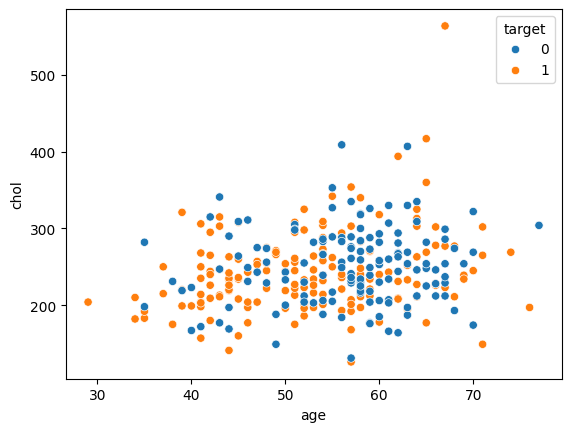

In [ ]:
# Ubah data Spark DataFrame ke Pandas DataFrame
pandas_df = df.toPandas()

# Buat scatter plot
sns.scatterplot(x='age', y='chol', hue='target', data=pandas_df)
plt.show()

### **Exploratory Data Analysis**

### Heatmap

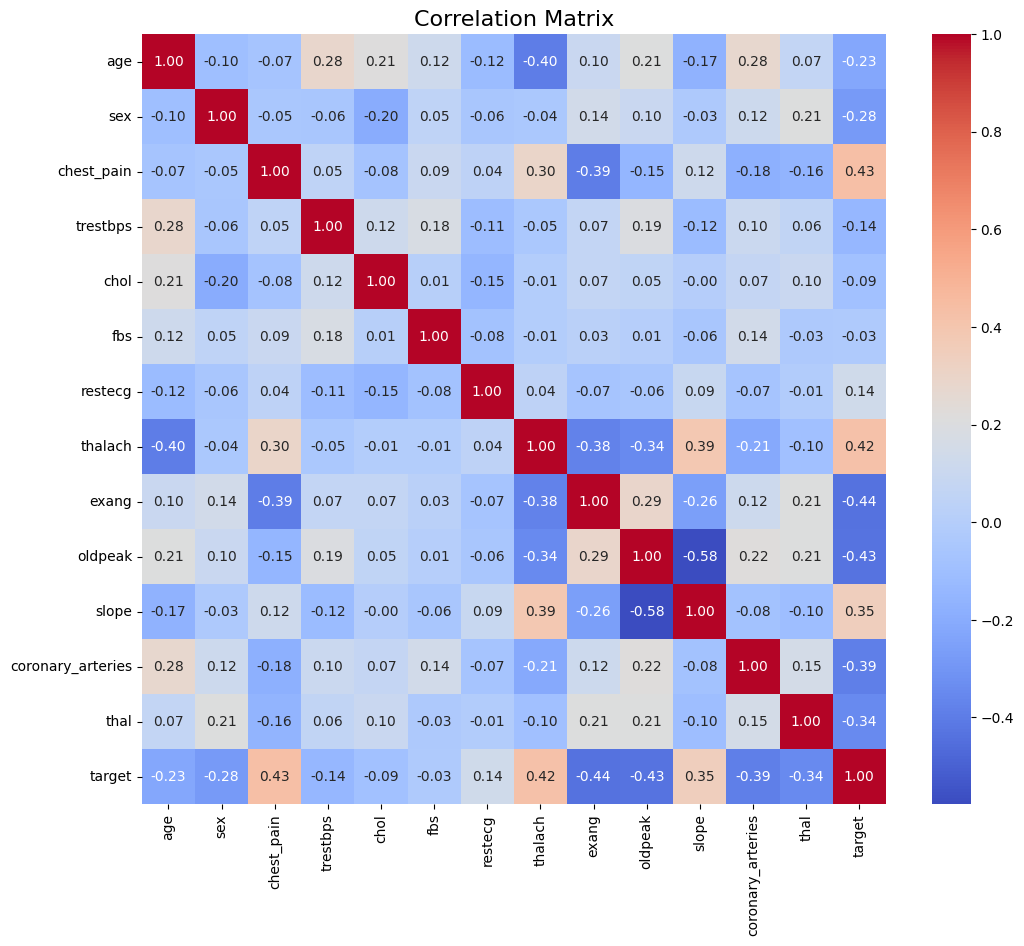

In [ ]:
# Hitung korelasi
correlation_matrix = df.toPandas().corr()

# Visualisasi heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', cbar=True)
plt.title('Correlation Matrix', fontsize=16)
plt.show()

### Analisis Variabel Target

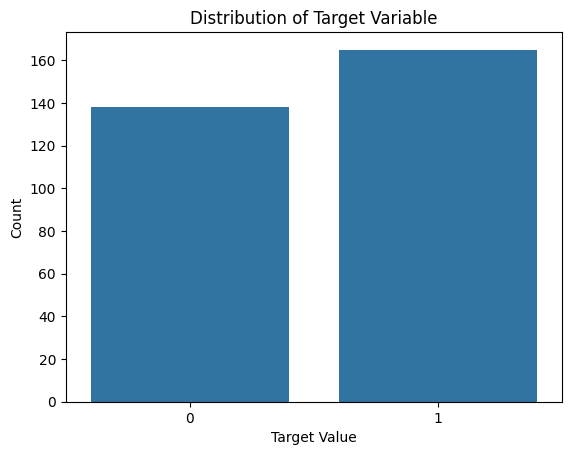

+------+-----+
|target|count|
+------+-----+
|     0|  138|
|     1|  165|
+------+-----+



In [ ]:
target_series = df.select("target").toPandas()["target"]

sns.countplot(x=target_series)
plt.xlabel("Target Value")
plt.ylabel("Count")
plt.title("Distribution of Target Variable")
plt.show()

target_temp = df.groupBy("target").count().orderBy("target")
target_temp.show()

In [ ]:
target_temp_values = target_temp.collect()

count_0 = target_temp_values[0]['count']
count_1 = target_temp_values[1]['count']

print("Percentage of patience without heart problems: "+str(round(count_0*100/303,2)))
print("Percentage of patience with heart problems: "+str(round(count_1*100/303,2)))

Percentage of patience without heart problems: 45.54
Percentage of patience with heart problems: 54.46


### Analisis Fitur Sex

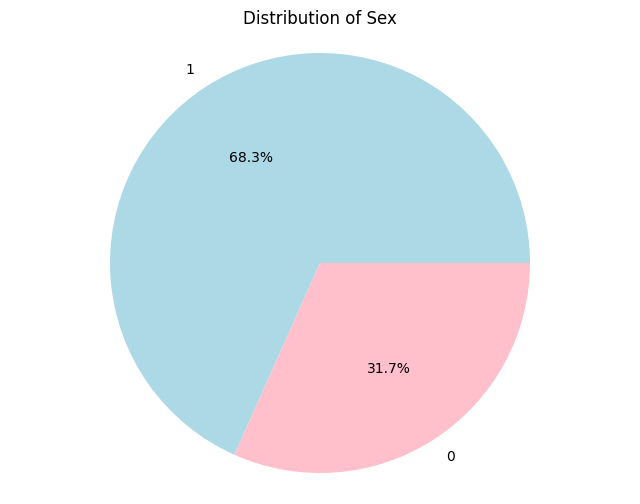

In [ ]:
sex_counts = df.groupBy("sex").count().toPandas()

plt.figure(figsize=(8, 6))
plt.pie(sex_counts['count'], labels=sex_counts['sex'], autopct='%1.1f%%', colors=['lightblue', 'pink'])
plt.title('Distribution of Sex')
plt.axis('equal')
plt.show()

## Analisis Fitur Age

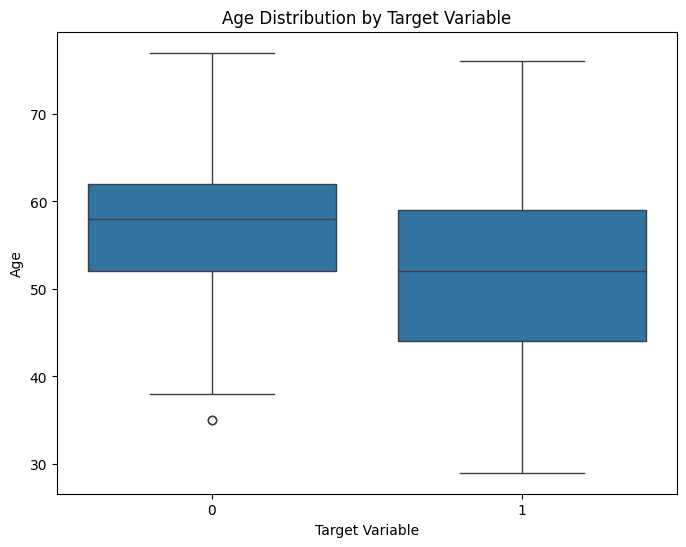

In [ ]:
plt.figure(figsize=(8, 6))
sns.boxplot(x="target", y="age", data=df.toPandas())
plt.xlabel("Target Variable")
plt.ylabel("Age")
plt.title("Age Distribution by Target Variable")
plt.show()

## Analisis Fitur Chol

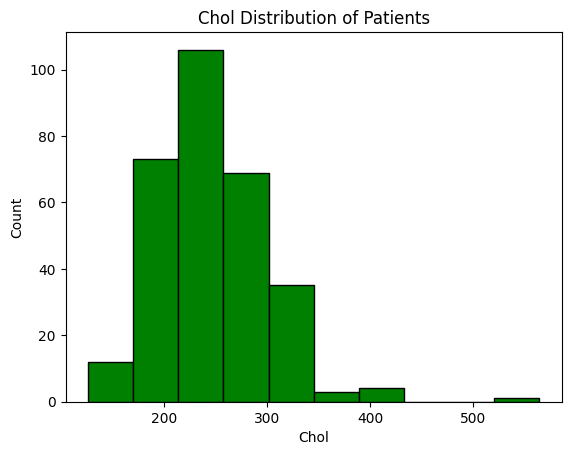

In [ ]:
chol_data = df.select("chol").toPandas()

plt.hist(chol_data["chol"], bins=10, color='green', edgecolor='black')
plt.title("Chol Distribution of Patients")
plt.xlabel("Chol")
plt.ylabel("Count")
plt.show()

# Histogram atau KDE plot untuk fitur numerik seperti age, chol, thalach, atau trestbps.

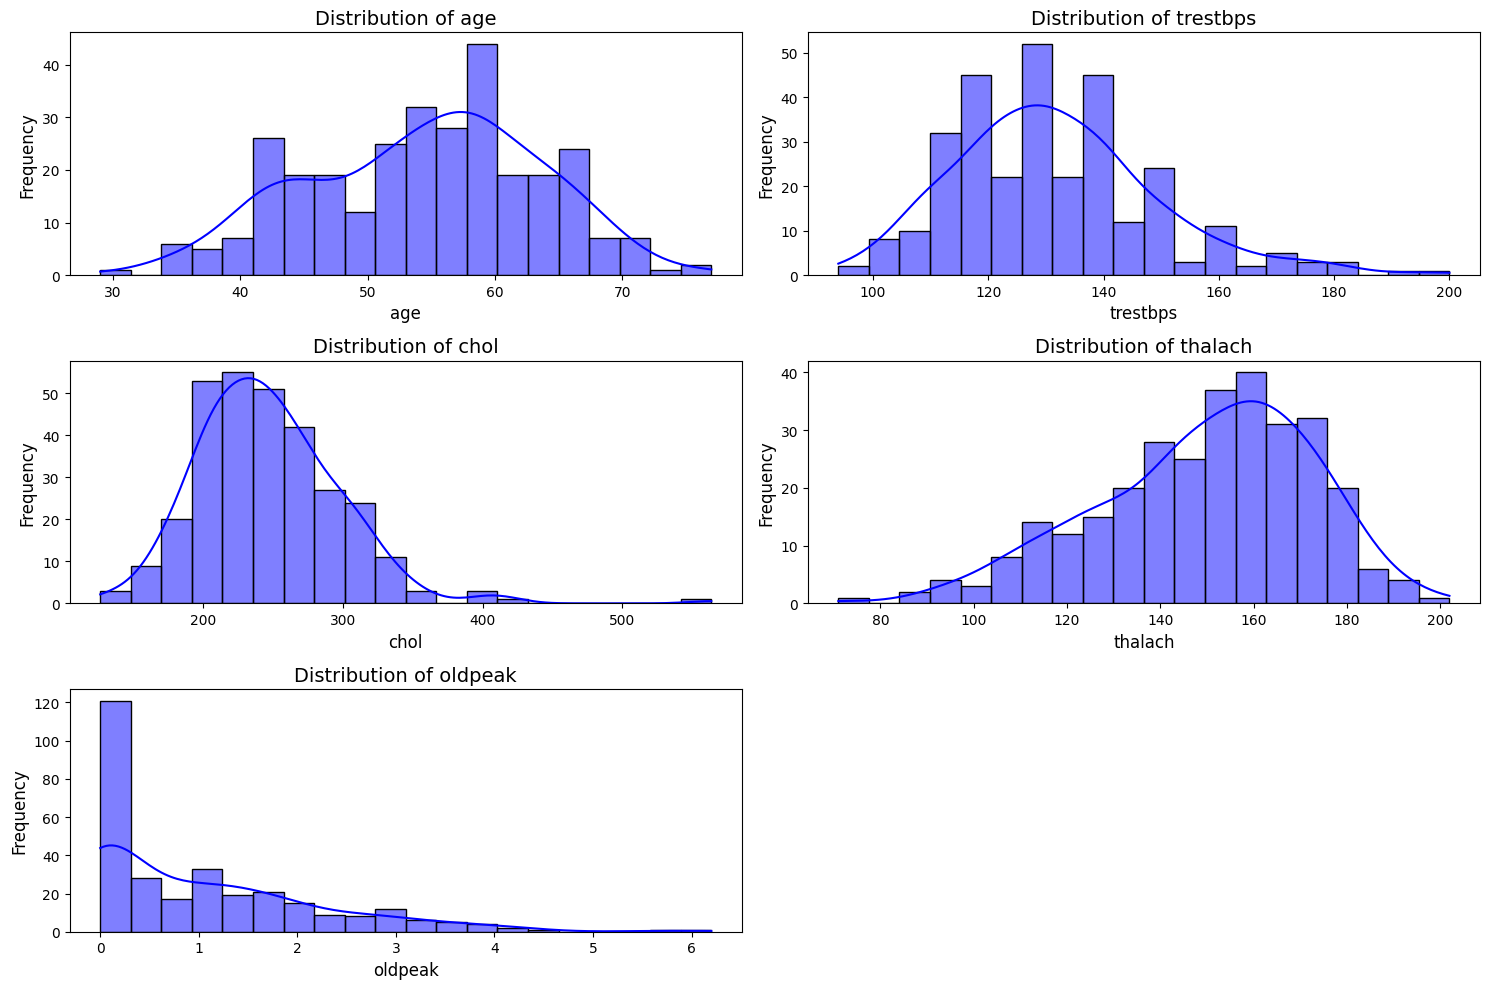

In [ ]:
# Pilih hanya kolom numerik dari dataset
numerical_features = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']

# Ukuran plot
plt.figure(figsize=(15, 10))

# Loop melalui setiap fitur numerik
for i, feature in enumerate(numerical_features, 1):
    plt.subplot(3, 2, i)  # Buat grid subplot (3 baris, 2 kolom)
    # Ganti heart_data dengan df.toPandas() untuk mengakses data
    sns.histplot(data=df.toPandas(), x=feature, kde=True, color='blue', bins=20)
    plt.title(f'Distribution of {feature}', fontsize=14)
    plt.xlabel(feature, fontsize=12)
    plt.ylabel('Frequency', fontsize=12)

plt.tight_layout()
plt.show()

## Train, Test, Split Data

In [ ]:
train_data, test_data = df_vector.randomSplit([0.8, 0.2], seed=0)

print(f"Jumlah data training: {train_data.count()}")
print(f"Jumlah data testing: {test_data.count()}")

Jumlah data training: 243
Jumlah data testing: 60


## MODEL MACHINE LEARNING

### **RANDOM FOREST**

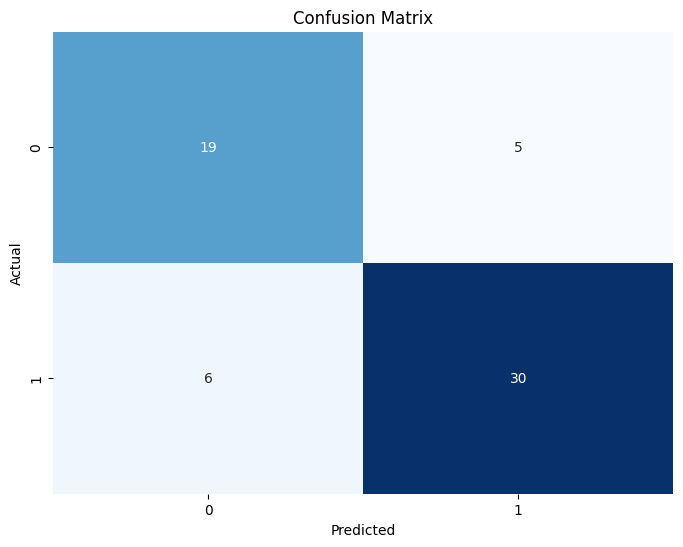

              precision    recall  f1-score   support

           0       0.76      0.79      0.78        24
           1       0.86      0.83      0.85        36

    accuracy                           0.82        60
   macro avg       0.81      0.81      0.81        60
weighted avg       0.82      0.82      0.82        60



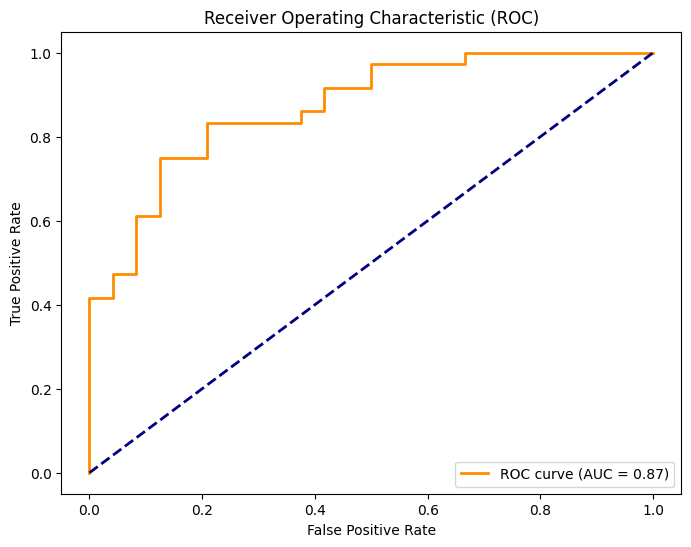

In [ ]:
# Train a RandomForestClassifier model
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc # Import necessary libraries


rf = RandomForestClassifier(labelCol="target", featuresCol="features", probabilityCol="probability")
rf_model = rf.fit(train_data)
rf_predictions = rf_model.transform(test_data)

# Evaluate the model
evaluator = MulticlassClassificationEvaluator(labelCol="target", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(rf_predictions)

# Convert to pandas DataFrame for classification report and confusion matrix
y_true = rf_predictions.select("target").toPandas()
y_pred = rf_predictions.select("prediction").toPandas()

# Calculate Confusion Matrix
# Use 'cm' instead of 'confusion_matrix' to avoid overwriting the function
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# Classification Report
report = classification_report(y_true, y_pred)
print(report)

# Calculate ROC and AUC
y_true_roc = rf_predictions.select("target").toPandas()
y_prob_roc = rf_predictions.select("probability").toPandas()

y_prob_roc = y_prob_roc['probability'].apply(lambda x: x[1])

fpr, tpr, thresholds = roc_curve(y_true_roc, y_prob_roc)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

### **Gradient Boost Tree**

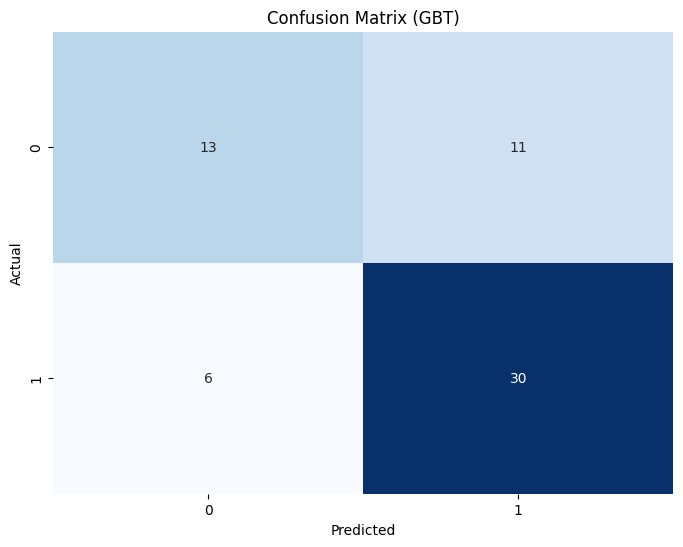

              precision    recall  f1-score   support

           0       0.68      0.54      0.60        24
           1       0.73      0.83      0.78        36

    accuracy                           0.72        60
   macro avg       0.71      0.69      0.69        60
weighted avg       0.71      0.72      0.71        60



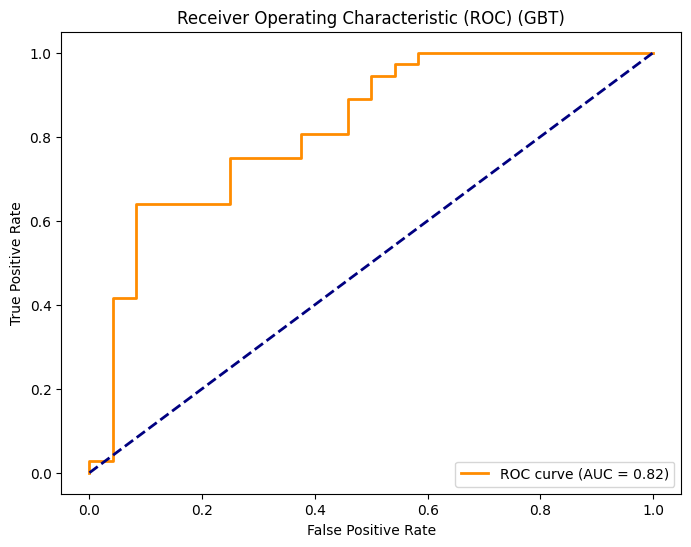

In [ ]:
# Train a GBTClassifier model
gbt = GBTClassifier(labelCol="target", featuresCol="features", maxIter=10)
gbt_model = gbt.fit(train_data)
gbt_predictions = gbt_model.transform(test_data)

# Evaluate the model
evaluator = MulticlassClassificationEvaluator(labelCol="target", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(gbt_predictions)

# Convert to pandas DataFrame for classification report and confusion matrix
y_true = gbt_predictions.select("target").toPandas()
y_pred = gbt_predictions.select("prediction").toPandas()

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix (GBT)")
plt.show()

# Classification Report
report = classification_report(y_true, y_pred)
print(report)

# Calculate ROC and AUC
y_true_roc = gbt_predictions.select("target").toPandas()
y_prob_roc = gbt_predictions.select("probability").toPandas()

# Assuming probability is a vector, extract the probability for class 1
y_prob_roc = y_prob_roc['probability'].apply(lambda x: x[1])

fpr, tpr, thresholds = roc_curve(y_true_roc, y_prob_roc)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) (GBT)')
plt.legend(loc="lower right")
plt.show()

### **XGBOOST**

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [05:13:53] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


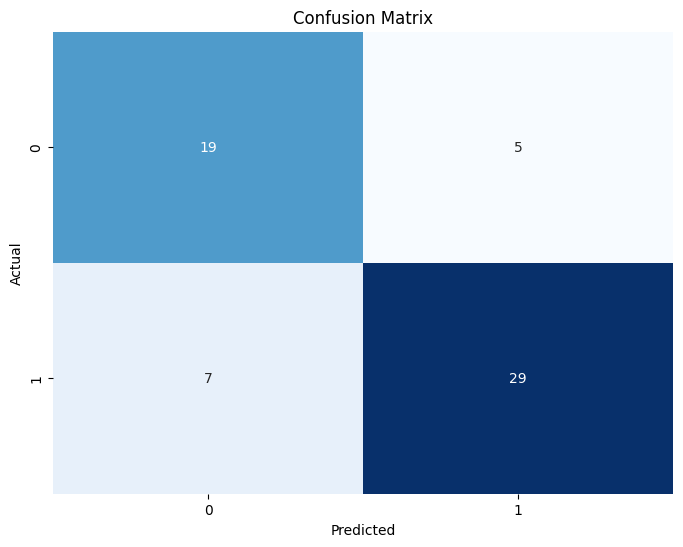

Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.79      0.76        24
           1       0.85      0.81      0.83        36

    accuracy                           0.80        60
   macro avg       0.79      0.80      0.79        60
weighted avg       0.80      0.80      0.80        60



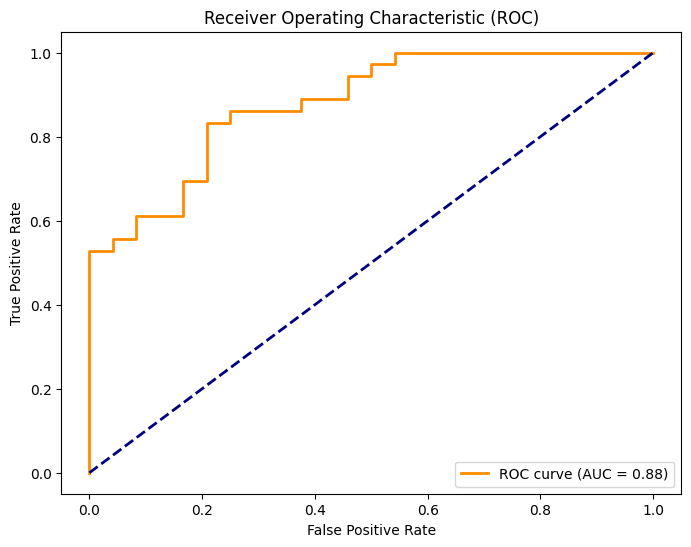

In [ ]:
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

# Konversi data Spark ke Pandas
train_df = train_data.select("features", "target").toPandas()
test_df = test_data.select("features", "target").toPandas()

# Pisahkan fitur dan target
X_train = list(train_df['features'])
y_train = train_df['target']
X_test = list(test_df['features'])
y_test = test_df['target']

# Train an XGBoost model
xgb = XGBClassifier(use_label_encoder=False, eval_metric="logloss", n_estimators=100, learning_rate=0.1, max_depth=6)
xgb.fit(X_train, y_train)

# Prediksi pada data uji
y_pred = xgb.predict(X_test)
y_prob = xgb.predict_proba(X_test)[:, 1]

# Evaluasi model
accuracy = xgb.score(X_test, y_test)

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# Classification Report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# ROC and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()


### Naive Bayes

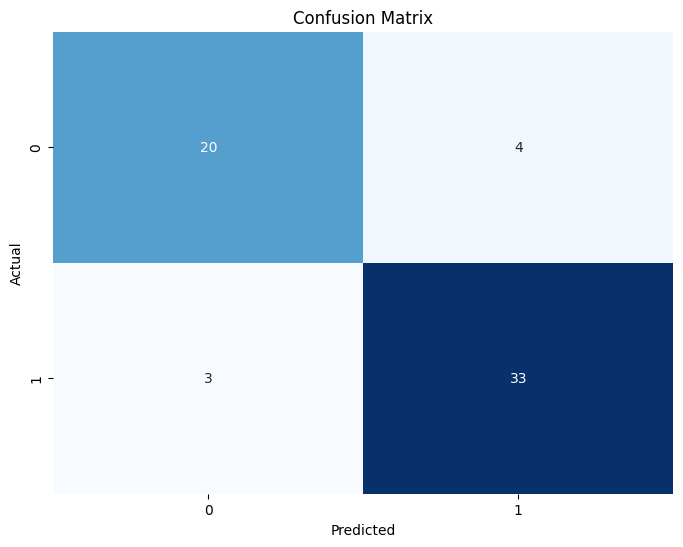

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.83      0.85        24
           1       0.89      0.92      0.90        36

    accuracy                           0.88        60
   macro avg       0.88      0.88      0.88        60
weighted avg       0.88      0.88      0.88        60



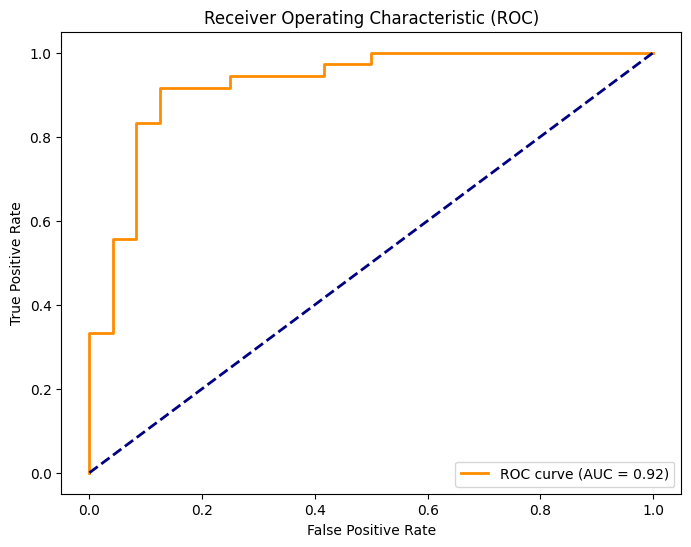

In [ ]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np # Import numpy for array operations

# Konversi data Spark ke Pandas
train_df = train_data.select("features", "target").toPandas()
test_df = test_data.select("features", "target").toPandas()

# Pisahkan fitur dan target
X_train = list(train_df['features'])
y_train = train_df['target']
X_test = list(test_df['features'])
y_test = test_df['target']

# Konversi ke array NumPy (diperlukan untuk Naive Bayes)
# Convert each DenseVector in X_train and X_test to a NumPy array
X_train = np.array([x.toArray() for x in X_train])
X_test = np.array([x.toArray() for x in X_test])

# Train a Gaussian Naive Bayes model
nb = GaussianNB()
nb.fit(X_train, y_train)

# Prediksi pada data uji
y_pred = nb.predict(X_test)
y_prob = nb.predict_proba(X_test)[:, 1]  # Probabilitas kelas positif

# Evaluasi model
accuracy = nb.score(X_test, y_test)

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# Classification Report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# ROC and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

### **Hyperparameter Tuning Random Forest**

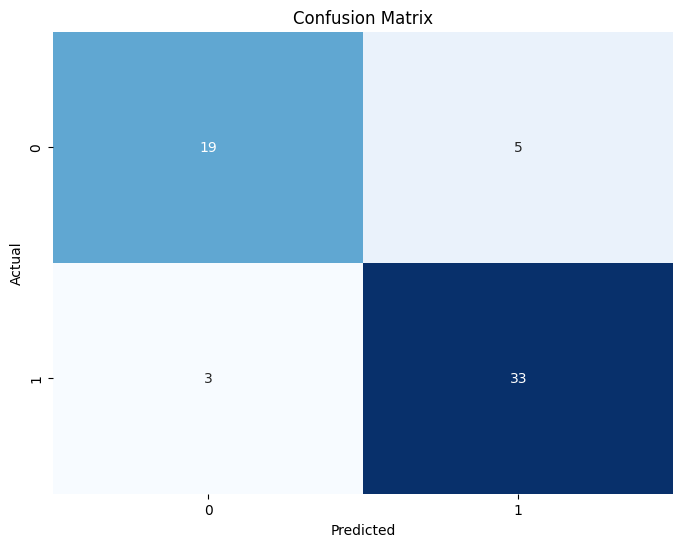

              precision    recall  f1-score   support

           0       0.86      0.79      0.83        24
           1       0.87      0.92      0.89        36

    accuracy                           0.87        60
   macro avg       0.87      0.85      0.86        60
weighted avg       0.87      0.87      0.87        60



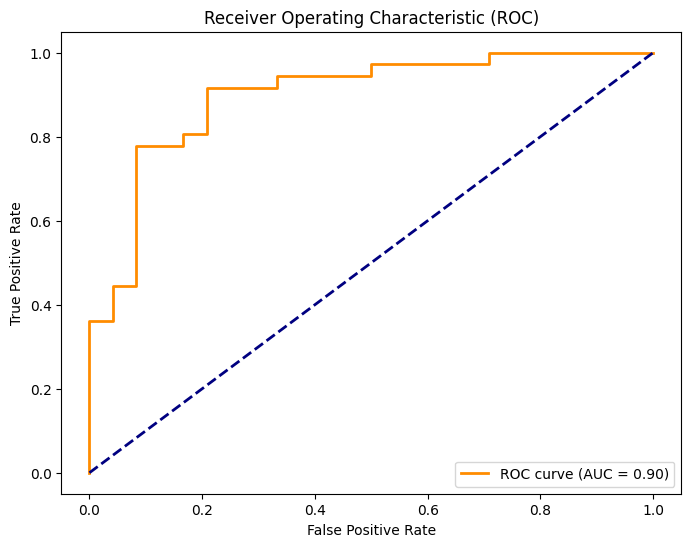

AUC: 0.8981


In [ ]:

from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from sklearn.metrics import classification_report, roc_curve, auc
from sklearn.metrics import confusion_matrix as cm_func # Import with alias
import matplotlib.pyplot as plt
import seaborn as sns


# Define the parameter grid for hyperparameter tuning
paramGrid = ParamGridBuilder() \
    .addGrid(rf.numTrees, [10, 20, 30]) \
    .addGrid(rf.maxDepth, [5, 10, 15]) \
    .build()

# Define the evaluator for cross-validation
evaluator = BinaryClassificationEvaluator(labelCol="target", rawPredictionCol="rawPrediction", metricName="areaUnderROC")

# Create the cross-validator
cv = CrossValidator(estimator=rf, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=15)

# Run cross-validation
cvModel = cv.fit(train_data)

# Evaluate the best model
predictions = cvModel.transform(test_data)

# Evaluate the best model with various metrics
evaluator_accuracy = MulticlassClassificationEvaluator(labelCol="target", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator_accuracy.evaluate(predictions)

# Convert to pandas DataFrame for classification report and confusion matrix
y_true = predictions.select("target").toPandas()
y_pred = predictions.select("prediction").toPandas()

# Calculate Confusion Matrix using cm_func
cm = cm_func(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# Classification Report
report = classification_report(y_true, y_pred)
print(report)

# Calculate ROC and AUC
y_true_roc = predictions.select("target").toPandas()
y_prob_roc = predictions.select("probability").toPandas()
y_prob_roc = y_prob_roc['probability'].apply(lambda x: x[1])
fpr, tpr, thresholds = roc_curve(y_true_roc, y_prob_roc)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

# Print AUC
print(f"AUC: {roc_auc:.4f}")


### **Hyperparameter Tuning Naive Bayes**

Fitting 10 folds for each of 500 candidates, totalling 5000 fits
Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.83      0.85        24
           1       0.89      0.92      0.90        36

    accuracy                           0.88        60
   macro avg       0.88      0.88      0.88        60
weighted avg       0.88      0.88      0.88        60



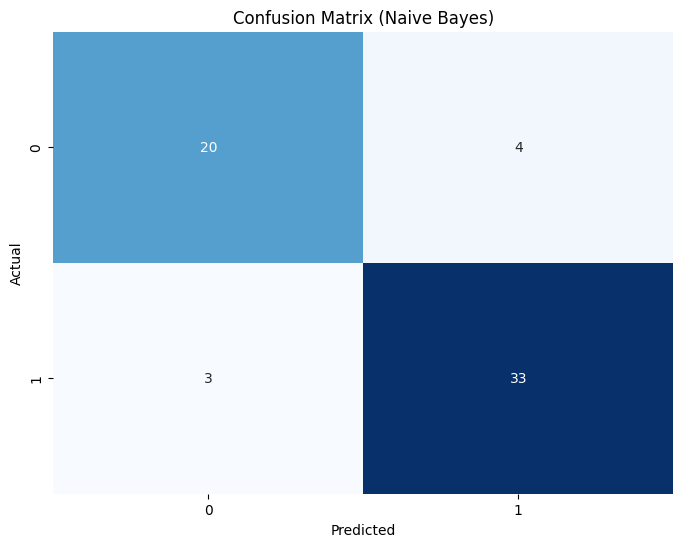

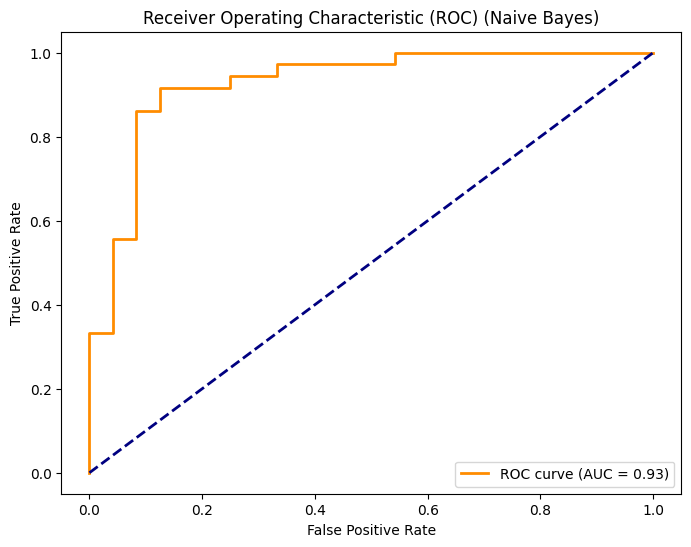

Best Hyperparameters: {'var_smoothing': 0.041422324724838894}


In [ ]:
import numpy as np
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE  # For oversampling
import matplotlib.pyplot as plt
import seaborn as sns

# Convert Spark DataFrame to Pandas DataFrame
train_pd = train_data.select("features", "target").toPandas()
test_pd = test_data.select("features", "target").toPandas()

# Separate features and target
X_train = np.array([x.toArray() for x in train_pd['features']])
y_train = train_pd['target']
X_test = np.array([x.toArray() for x in test_pd['features']])
y_test = test_pd['target']

# Normalize the features using StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Handle class imbalance with SMOTE (Oversampling minority class)
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_scaled, y_train)

# Define the parameter grid for Naive Bayes
param_grid_nb = {
    'var_smoothing': np.logspace(-15, 0, num=500)  # Further extended range for tuning
}

# Initialize Gaussian Naive Bayes
nb = GaussianNB()

# Initialize KFold with a slightly lower number of splits
kfold = KFold(n_splits=10, shuffle=True, random_state=42)

# Perform GridSearchCV with KFold cross-validation
grid_search_nb = GridSearchCV(
    estimator=nb,
    param_grid=param_grid_nb,
    cv=kfold,
    scoring='roc_auc',  # Focus on AUC for better generalization
    n_jobs=-1,
    verbose=1
)
grid_search_nb.fit(X_train_balanced, y_train_balanced)

# Get the best model
best_nb = grid_search_nb.best_estimator_

# Predict on the test set using the best model
y_pred = best_nb.predict(X_test_scaled)
y_prob = best_nb.predict_proba(X_test_scaled)[:, 1]

# Evaluate the model
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix (Naive Bayes)")
plt.show()

# ROC and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) (Naive Bayes)')
plt.legend(loc="lower right")
plt.show()

print(f"Best Hyperparameters: {grid_search_nb.best_params_}")


In [ ]:

# import numpy as np
# from sklearn.naive_bayes import GaussianNB
# from sklearn.model_selection import KFold, GridSearchCV
# from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
# import matplotlib.pyplot as plt
# import seaborn as sns
# from pyspark.ml.evaluation import BinaryClassificationEvaluator

# # ... (previous code remains the same)

# # ### Naive Bayes with Hyperparameter Tuning and K-Fold Cross-Validation

# # Convert Spark DataFrame to Pandas DataFrame
# train_pd = train_data.select("features", "target").toPandas()
# test_pd = test_data.select("features", "target").toPandas()

# # Separate features and target
# X_train = np.array([x.toArray() for x in train_pd['features']])
# y_train = train_pd['target']
# X_test = np.array([x.toArray() for x in test_pd['features']])
# y_test = test_pd['target']

# # Define the parameter grid for Naive Bayes
# param_grid_nb = {
#     'var_smoothing': np.logspace(-10,1, num=100)
# }


# # Initialize Gaussian Naive Bayes
# nb = GaussianNB()

# # Initialize KFold
# kfold = KFold(n_splits=10, shuffle=True, random_state=42)

# # Perform GridSearchCV with KFold cross-validation
# grid_search_nb = GridSearchCV(estimator=nb, param_grid=param_grid_nb, cv=kfold, scoring='accuracy', n_jobs=-1, verbose=1)
# grid_search_nb.fit(X_train, y_train)

# # Get the best model
# best_nb = grid_search_nb.best_estimator_

# # Predict on the test set using the best model
# y_pred = best_nb.predict(X_test)
# y_prob = best_nb.predict_proba(X_test)[:, 1]

# # Evaluate the model
# print("Classification Report:")
# print(classification_report(y_test, y_pred))

# # Confusion Matrix
# cm = confusion_matrix(y_test, y_pred)
# plt.figure(figsize=(8, 6))
# sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
# plt.xlabel("Predicted")
# plt.ylabel("Actual")
# plt.title("Confusion Matrix (Naive Bayes)")
# plt.show()


# # ROC and AUC
# fpr, tpr, thresholds = roc_curve(y_test, y_prob)
# roc_auc = auc(fpr, tpr)

# # Plot ROC curve
# plt.figure(figsize=(8, 6))
# plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
# plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('Receiver Operating Characteristic (ROC) (Naive Bayes)')
# plt.legend(loc="lower right")
# plt.show()

# print(f"Best Hyperparameters: {grid_search_nb.best_params_}")

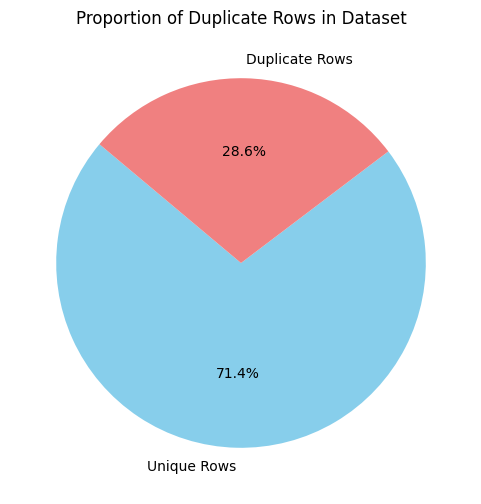

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Membuat contoh dataset untuk simulasi (pengganti dataset asli)
data = {
    'age': [63, 37, 41, 56, 57, 63, 63],
    'sex': [1, 1, 0, 1, 0, 1, 1],
    'cp': [3, 2, 1, 1, 0, 3, 3],
    'trestbps': [145, 130, 130, 120, 120, 145, 145],
    'chol': [233, 250, 204, 236, 354, 233, 233],
    'target': [1, 1, 0, 1, 0, 1, 1]
}
df = pd.DataFrame(data)

# Memeriksa nilai duplikat
duplicates = df.duplicated()

# Visualisasi jumlah duplikat
dupes_count = duplicates.sum()
labels = ['Unique Rows', 'Duplicate Rows']
sizes = [len(df) - dupes_count, dupes_count]
colors = ['skyblue', 'lightcoral']

plt.figure(figsize=(6, 6))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140, colors=colors)
plt.title('Proportion of Duplicate Rows in Dataset')
plt.show()

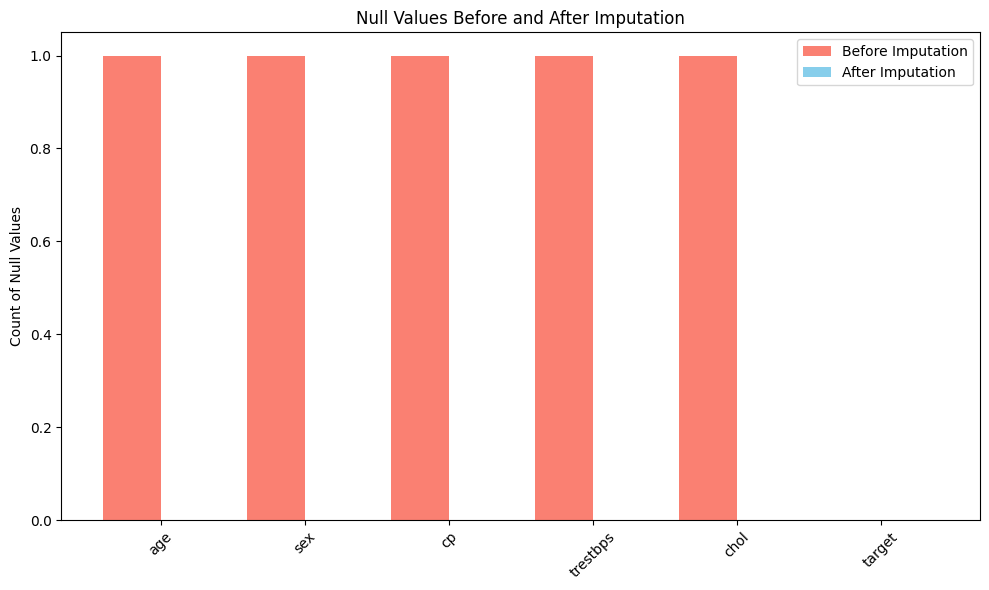

In [ ]:
import numpy as np

# Contoh dataset dengan nilai null (simulasi)
data_with_null = {
    'age': [63, 37, np.nan, 56, 57, 63, 63],
    'sex': [1, 1, 0, 1, 0, np.nan, 1],
    'cp': [3, 2, 1, np.nan, 0, 3, 3],
    'trestbps': [145, 130, 130, 120, np.nan, 145, 145],
    'chol': [233, np.nan, 204, 236, 354, 233, 233],
    'target': [1, 1, 0, 1, 0, 1, 1]
}
df_with_null = pd.DataFrame(data_with_null)

# Menampilkan jumlah nilai null sebelum imputasi
null_counts_before = df_with_null.isnull().sum()

# Imputasi nilai null dengan median
df_imputed = df_with_null.fillna(df_with_null.median())

# Menampilkan jumlah nilai null setelah imputasi
null_counts_after = df_imputed.isnull().sum()

# Visualisasi nilai null sebelum dan sesudah imputasi
labels = df_with_null.columns
x = np.arange(len(labels))

plt.figure(figsize=(10, 6))
plt.bar(x - 0.2, null_counts_before, width=0.4, label='Before Imputation', color='salmon')
plt.bar(x + 0.2, null_counts_after, width=0.4, label='After Imputation', color='skyblue')
plt.xticks(x, labels, rotation=45)
plt.ylabel('Count of Null Values')
plt.title('Null Values Before and After Imputation')
plt.legend()
plt.tight_layout()
plt.show()

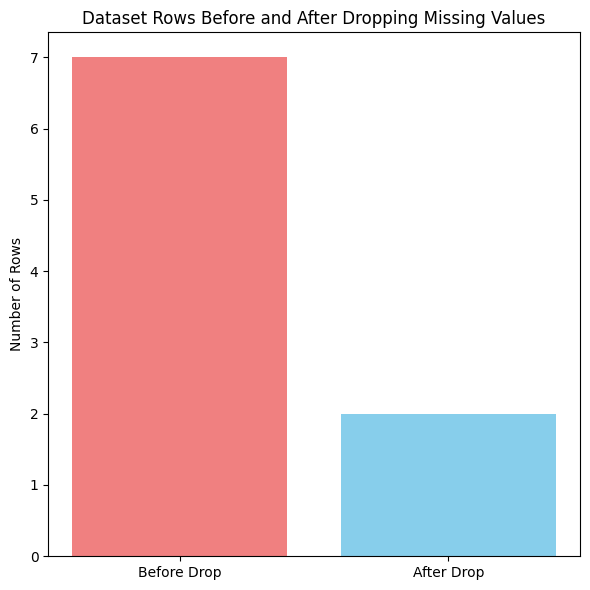

In [ ]:
# Menghitung jumlah nilai null sebelum drop
null_counts_before_drop = df_with_null.isnull().sum().sum()
rows_before_drop = len(df_with_null)

# Menghapus baris dengan nilai null
df_dropped = df_with_null.dropna()

# Menghitung jumlah nilai null setelah drop
null_counts_after_drop = df_dropped.isnull().sum().sum()
rows_after_drop = len(df_dropped)

# Visualisasi jumlah baris sebelum dan setelah penghapusan
labels = ['Before Drop', 'After Drop']
values = [rows_before_drop, rows_after_drop]

plt.figure(figsize=(6, 6))
plt.bar(labels, values, color=['lightcoral', 'skyblue'])
plt.ylabel('Number of Rows')
plt.title('Dataset Rows Before and After Dropping Missing Values')
plt.tight_layout()
plt.show()

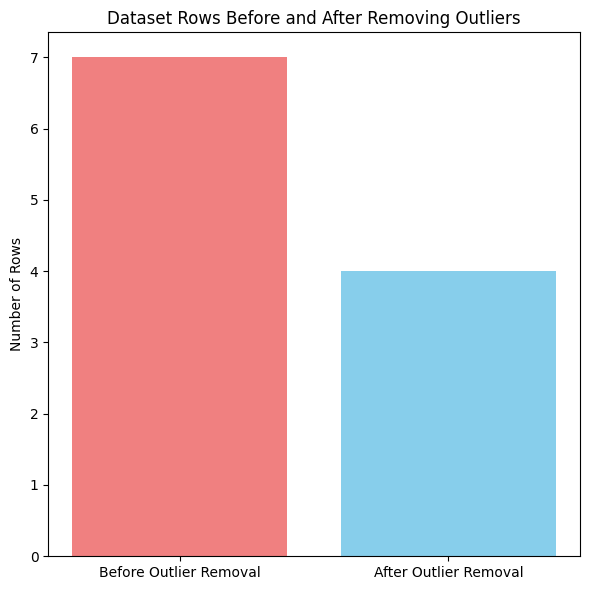

In [ ]:
# Menghitung Q1, Q3, dan IQR untuk mendeteksi outlier
Q1 = df_imputed.quantile(0.25)
Q3 = df_imputed.quantile(0.75)
IQR = Q3 - Q1

# Mendefinisikan batas bawah dan atas untuk outlier
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Menghapus outlier
df_no_outliers = df_imputed[~((df_imputed < lower_bound) | (df_imputed > upper_bound)).any(axis=1)]

# Visualisasi jumlah data sebelum dan setelah penghapusan outlier
labels = ['Before Outlier Removal', 'After Outlier Removal']
values = [len(df_imputed), len(df_no_outliers)]

plt.figure(figsize=(6, 6))
plt.bar(labels, values, color=['lightcoral', 'skyblue'])
plt.ylabel('Number of Rows')
plt.title('Dataset Rows Before and After Removing Outliers')
plt.tight_layout()
plt.show()

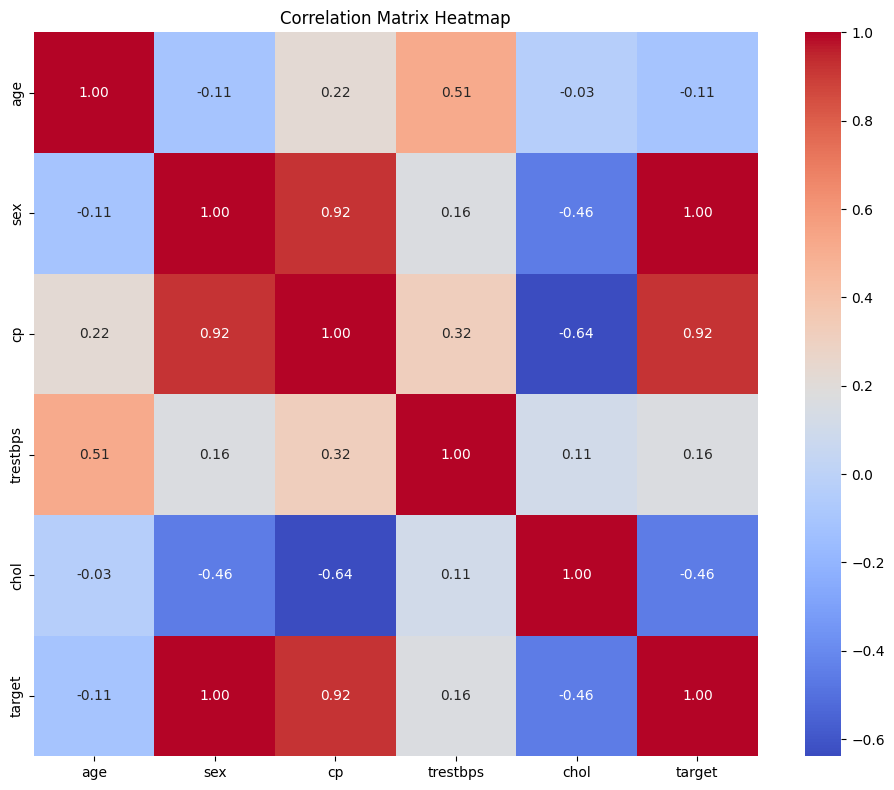

In [ ]:
import seaborn as sns

# Menghitung matriks korelasi
correlation_matrix = df_imputed.corr()

# Visualisasi matriks korelasi menggunakan heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True, square=True)
plt.title("Correlation Matrix Heatmap")
plt.tight_layout()
plt.show()

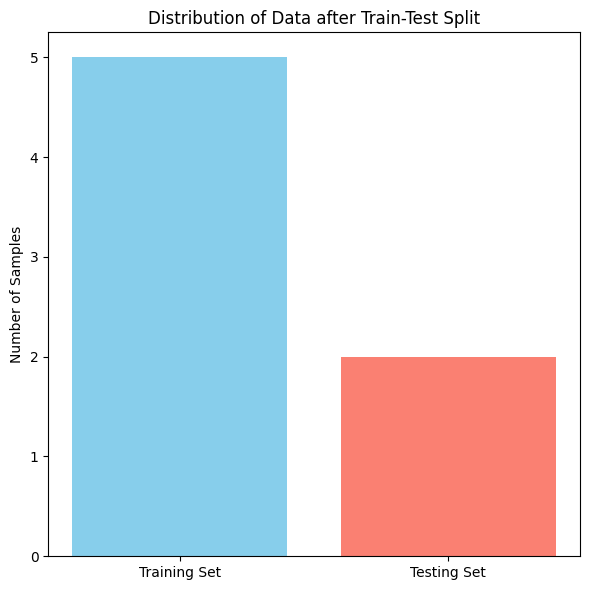

In [ ]:
from sklearn.model_selection import train_test_split

# Memisahkan fitur dan target
X = df_imputed.drop(columns=['target'])
y = df_imputed['target']

# Membagi data menjadi training set (80%) dan testing set (20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Menghitung jumlah data pada masing-masing subset
subset_sizes = [len(X_train), len(X_test)]
labels = ['Training Set', 'Testing Set']

# Visualisasi hasil split data
plt.figure(figsize=(6, 6))
plt.bar(labels, subset_sizes, color=['skyblue', 'salmon'])
plt.ylabel('Number of Samples')
plt.title('Distribution of Data after Train-Test Split')
plt.tight_layout()
plt.show()